In [3]:
# imports
import kagglehub

import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image  # For image processing
from sklearn.model_selection import train_test_split # For splitting data
import tensorflow as tf # For image processing



In [ ]:
# Dataset retrieval
path = kagglehub.dataset_download("shaunthesheep/microsoft-catsvsdogs-dataset")

print("Path to dataset files:", path)

Number of images: 12499
Unique widths: 416
Unique heights: 435


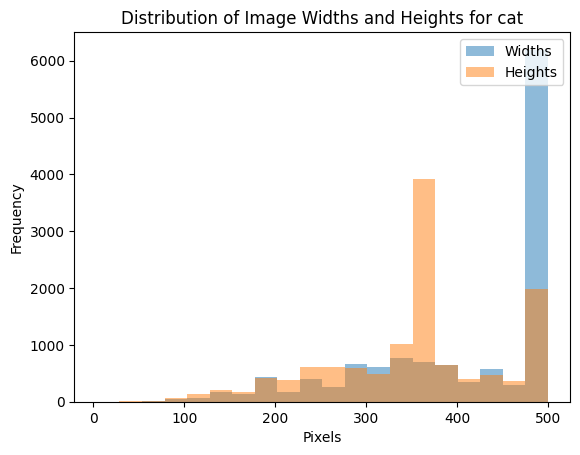

Error opening image 11702.jpg: cannot identify image file '/root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1/PetImages/Dog/11702.jpg'
Number of images: 12499
Unique widths: 425
Unique heights: 435


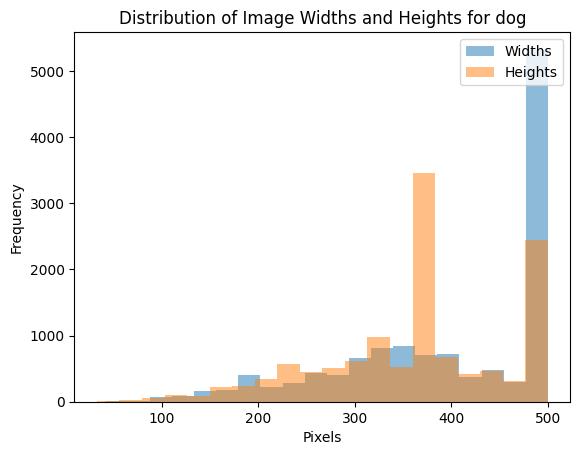

In [12]:
# check if images need to be resized.

data_dir_cat = '/root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1/PetImages/Cat'  # Cat data directory
data_dir_dog = '/root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1/PetImages/Dog'

def check_if_resizing_needed(data_dir, animal_type):
  image_files = [f for f in os.listdir(data_dir) if f.endswith('.jpg')] # Get only jpg files

  widths = []
  heights = []

  for image_file in image_files:
      image_path = os.path.join(data_dir, image_file)
      try:
          img = Image.open(image_path)
          width, height = img.size
          widths.append(width)
          heights.append(height)
      except Exception as e: # Handle potential errors (e.g., corrupted files)
          print(f"Error opening image {image_file}: {e}")

  # Analyze the dimensions
  print(f"Number of images: {len(widths)}")
  print(f"Unique widths: {len(set(widths))}")
  print(f"Unique heights: {len(set(heights))}")

  plt.hist(widths, bins=20, alpha=0.5, label='Widths')
  plt.hist(heights, bins=20, alpha=0.5, label='Heights')
  plt.legend(loc='upper right')
  plt.title(f'Distribution of Image Widths and Heights for {animal_type}')
  plt.xlabel('Pixels')
  plt.ylabel('Frequency')
  plt.show()

check_if_resizing_needed(data_dir_cat, 'cat')
check_if_resizing_needed(data_dir_dog, 'dog')

# remove images with errors
# os.remove("/root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1/PetImages/Cat/666.jpg")
# os.remove("/root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1/PetImages/Dog/11702.jpg")

In [18]:
from collections import Counter

# standardizing image sizes. Given the distribution of width and heights, 256x256 seems good to retain some details.

new_width = 256
new_height = 256

def resize_images_in_directories(data_dirs, max_dimension=256, output_dir_base="resized_images"):
    """Resizes images in multiple directories, maintaining aspect ratio."""

    for data_dir in data_dirs:
        output_dir = os.path.join(output_dir_base, os.path.basename(data_dir))  # Create separate output directories for each input
        os.makedirs(output_dir, exist_ok=True)  # Create the output directory if it doesn't exist
        resize_images(data_dir, output_dir, max_dimension)


def resize_images(data_dir, output_dir, max_dimension):
    image_files = [f for f in os.listdir(data_dir) if f.endswith(('.jpg'))]
    resized_images =  []
    for image_file in image_files:
        image_path = os.path.join(data_dir, image_file)
        resized_image = resize_image_keeping_aspect_ratio(image_path, max_dimension)
        if resized_image is not None:
            resized_images.append(resized_image)

    # Convert to NumPy array after checking shapes
    if resized_images:  # Check if the list is not empty
        shapes = [np.array(img).shape for img in resized_images]  # Get shapes of NumPy array representation
        unique_shapes = set(shapes)  # See if there are unique shapes

        if len(unique_shapes) > 1:  # If there are more than 1 shape, find the most common shape
            shape_counts = Counter(shapes)
            most_common_shape = shape_counts.most_common(1) # Get the most common shape
            print(f"Inconsistent image shapes detected. Enforcing shape: {most_common_shape}")
            resized_images = [img for img in resized_images if np.array(img).shape == most_common_shape]  # Keep only images with the most common shape

        try:
            resized_images = np.stack([np.array(img) for img in resized_images])  # Convert to NumPy array before stacking
            print(f"Resized images shape: {resized_images.shape}")
            # Normalize
            resized_images = resized_images / 255.0  # Normalize pixel values (important!)
            np.save(os.path.join(output_dir, "resized_images.npy"), resized_images)
        except ValueError as e:
            print(f"Error creating NumPy array: {e}")

def resize_image_keeping_aspect_ratio(image_path, max_dimension=256):
    try:
        img = Image.open(image_path)
        width, height = img.size

        if width > height:
            new_width = max_dimension
            new_height = int(height * (max_dimension / width))
        else:
            new_height = max_dimension
            new_width = int(width * (max_dimension / height))

        resized_img = img.resize((new_width, new_height), Image.LANCZOS)  # Use a high-quality resampling filter
        return resized_img  # Return the PIL Image object
    except (FileNotFoundError, OSError, SyntaxError, IOError) as e:  # Handle file errors
        print(f"Error processing image {image_path}: {e}")
        return None

data_directories = (data_dir_dog, data_dir_cat)
resize_images_in_directories(data_directories, max_dimension=256)

Inconsistent image shapes detected. Enforcing shape: [((192, 256, 3), 3443)]
Error creating NumPy array: need at least one array to stack
Inconsistent image shapes detected. Enforcing shape: [((192, 256, 3), 4008)]
Error creating NumPy array: need at least one array to stack


In [19]:
print(f"Resized images are in the output directory: resized_images")

#

Resized images are in the output directory: resized_images
